# <font size=6>**Assignment_3. Implement a method to improve the accuracy and speed of SVM**

<font size=2>*TP Authors : Chen Yuheng, Zhou Ziang*    

---


  
The paper by Burges and Schölkopf proposed a method to improve the accuracy and speed of SVM. The main idea of this method can be descirbed by three steps :

1.   train a classic SVC
2.   generate a artificile dataset by translating the supports vectors then train another SVC(combine incorporating knowledge)
3.   replace the news support vectors set by a reduce set to classifier new sample






# 0. Load MNIST dateset and import library
Same as the experiment in the paper, we divided the dataset into 60000 training sets and 10000 test sets

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

from scipy.ndimage.interpolation import shift
from scipy.io import loadmat
#from google.colab import drive
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#drive.mount('/content/drive')


In [2]:
#data = loadmat('/content/drive/MyDrive/AOS/AOS1/mnist-original.mat')
data = loadmat('PycharmProjects/pythonProject/mnist-original.mat')
X = data['data'].T  # X is unfolded, [n_features,n_samples] 784 x 70000 
y = data['label'].T  # [1,70000]
# Shuffle the data set
shuffer_index=np.random.permutation(X.shape[0])
X,y = X[shuffer_index], y[shuffer_index] 

X_train = X[0:60000,:]
X_test = X[60000:,:]
y_train = y[0:60000,:]
y_test = y[60000:,:]

Text(0.5, 1.0, 'This is a 4')

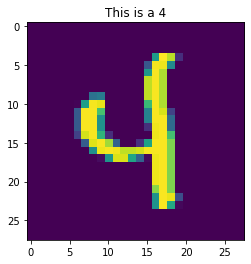

In [3]:
#display a random picture
indice = random.randint(1,70000)
im = X[indice,:].reshape((28,28))
plt.imshow(im)
plt.title("This is a " + str(int(y[indice,:])))

# 1. Train a SVM with the polynomial kernel and the hyperparameter C
---

Firstly, we train an svm according to the parameters of the paper with :

*   kernel = polynominal kernel
*   degree = 5
*   C = 10



In [4]:
# train a svm according to the paper
svm = SVC(kernel='poly',degree=5,C=10)
svm.fit(X_train,y_train)

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(C=10, degree=5, kernel='poly')

In [5]:
# perfomance of this model - svm
start = time.time()
pred_svm = svm.predict(X_test)
end = time.time()
score_svm = accuracy_score(y_test,pred_svm)
print("In svm, " + str(svm.support_vectors_.shape[0]) + " supports vectors are found")
print("It takes " + str(end-start) + " seconds to classifier the test set")
print("And the accurancy score is " + str(score_svm))

In svm, 8170 supports vectors are found
It takes 25.243671417236328 seconds to classifier the test set
And the accurancy score is 0.9682


#2. Improvement of accurency - VSV 
---
Same as the paper, we generate new training set by translating the resulting support vector by one pixel in each of four direction.

In [6]:
# generate new training set
def shift_image(digit_array,dx,dy,new=0):
  digit_im = digit_array.reshape(28,28)
  return shift(digit_im,[dx,dy],cval=new).reshape(784)

X_train_invariant = np.zeros((4*svm.support_vectors_.shape[0],784))
y_train_invariant = np.zeros((4*svm.support_vectors_.shape[0],1))

# translating the support vectors by one pixel in each of four direction
for i in range(svm.support_vectors_.shape[0]):
  X_train_invariant[4*i] = shift_image(svm.support_vectors_[i],0,1)
  X_train_invariant[4*i+1] = shift_image(svm.support_vectors_[i],0,-1)
  X_train_invariant[4*i+2] = shift_image(svm.support_vectors_[i],1,0)
  X_train_invariant[4*i+3] = shift_image(svm.support_vectors_[i],-1,0)
  for j in range(4):
    y_train_invariant[4*i+j] = y_train[svm.support_[i]]

X_train_invariant[X_train_invariant<1] = 0

In [7]:
# train a new svm with same parameter, which will be called vsv in follow text
vsv = SVC(kernel='poly',degree=5,C=10)
vsv.fit(X_train_invariant,y_train_invariant)

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(C=10, degree=5, kernel='poly')

In [8]:
# performance of the model - vsv
start = time.time()
pred_vsv = vsv.predict(X_test)
end = time.time()
score_vsv = accuracy_score(y_test,pred_vsv)
print("In vsv, " + str(vsv.support_vectors_.shape[0]) + " supports vectors are found")
print("It takes " + str(end-start) + " seconds to classifier the test set")
print("And the accurancy score is " + str(score_vsv))

In vsv, 20739 supports vectors are found
It takes 72.91207456588745 seconds to classifier the test set
And the accurancy score is 0.9814


# 3. Reduced set system - RS




 ---

The objet of this step is to find a set of vector $z_k$ and correspanding 
$\gamma_k$ to replace $\omega$
$$\omega = \sum_{j=1}^{N_s}\alpha_jy_j\phi(s_j) \to \omega' = \sum_{k=1}^{N_z}\gamma_k\phi(z_k)$$

for which minimize the distance between two hyperplane:
$$\rho = \parallel \omega - \omega' \parallel$$
with $N_k \ll N_s$, so that we can improve the speed of classification.  
  
However, $\rho$ can not always be minimized to $0$, which means the performance of the reduced model may not as good as VSV model. One of the solutions is to increase the threshould $b$ (instead of $1$) since $\omega'$ is an approximation of $\omega$



In order to understand how to find an approximate hyperplane, we read a paper "Simplied Support Vector Decision Rules" published by Chris J.C. Burges. The article mentioned a two-step OPTIMIZATION APPROCHE. "We start by summarizing the algorithm used. First, the desired order of approximation, $N_z$, is chosen. Let $X_i\equiv\{\gamma_i,z_i\}$. We used a two-phase approach. In phase 1, the $X_i$ are computed incrementally, keeping all $Xj, j < i$ fixed. In phase 2, all $X_i$ are allowed to vary."

**We tried many methods to approximate but were unsuccessful, and searched a lot of information but did not find it. So it is a pity that we failed to complete this step in the end.**


According to the paper, ''*While the reduced set can be found exactly in some cases, in general an unconstrained conjugate gradient method is used to find the $Z_k$ (while the corresponding optimal $\gamma_k$ can be found exactly, for all k).* '' **However, after several hours' investigation, we still can't figure out how to compute $Z_k$. So instead of computing $Z_k$, we take 800 random training samples of VSV model as our $Z_k$, and then we train a new svm model(just for the comparasion)**

In [9]:
# shuffle the data set, and then take the first 800 as Zk
shuffer_index_vsv=np.random.permutation(vsv.support_vectors_.shape[0])
Zk = vsv.support_vectors_[shuffer_index_vsv][:800]
yk = y_train_invariant[vsv.support_[shuffer_index_vsv][:800]]

# train another svm
rs = SVC(kernel='poly',degree=5,C=10)
rs.fit(Zk,yk)

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(C=10, degree=5, kernel='poly')

In [10]:
# performance of the model - rs
start = time.time()
pred_rs = rs.predict(X_test)
end = time.time()
score_rs = accuracy_score(y_test,pred_rs)
print("In rs, " + str(rs.support_vectors_.shape[0]) + " supports vectors are found")
print("It takes " + str(end-start) + " seconds to classifier the test set")
print("And the accurancy score is " + str(score_rs))

In rs, 794 supports vectors are found
It takes 1.5242576599121094 seconds to classifier the test set
And the accurancy score is 0.7909


#4. Conclusion
From **table** we can see the implementation of the svm improvement method discussed in the paper. Using the "virtual support vector" method can indeed increase the accuracy of the result by **1.15%**, but the corresponding running time has also increased by about **2.5** times.
**However, our RS is not correctly calculated, so even if the prediction speed has been improved, the accurency is decresed.**



| | SVM | VSV | RS |
|:----:|:-----:| :----: | :----: |
|**SV/RSV** | 8170 | 20739 |795|
|**Prediction time(s)**| 25 | 64 | 1.52 |
|**Accurancy(%)**| 96.62 | 98.14 | 79.09 |


